In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from scipy.special import binom

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import transforms
from torch.autograd import Variable
import torch.utils.data as data_utils
import torch.nn.init as init

from collections import Counter
import operator
import copy
from itertools import product,combinations
from time import time
#from IPython.core.display import display

%matplotlib inline

## code extracted from https://www.kaggle.com/code/graymant/breast-cancer-diagnosis-with-pytorch
## SV code extracted from https://

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import os
import sys
from os.path import join as osj
from bisect import bisect
from collections import defaultdict
import pickle
import json
#!pip install wfdb
import wfdb

In [6]:
def read_dict_beats():
    with open(DICT_BEATS, "rb") as f:
        return pickle.load(f)

def read_data_beats():
    with open(DATA_BEATS, "rb") as f:
        return pickle.load(f)

def ensure_normalized_and_detrended(beats):
    for key in beats.keys():
        b = beats[key]["beats"]
        if not np.allclose(np.linalg.norm(b, axis=1, ord=2), 1):
            raise AssertionError(f"Beats of patient {key} is not normalized.")

        p = np.polyfit(np.arange(b.shape[1]), b.T, deg=1)
        if not np.allclose(p, 0):
            raise AssertionError(f"Beats of patient {key} is not detrended.")

DATA_ROOT =  "/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/data"
DATA_BEATS = osj(DATA_ROOT, "30min_beats.pkl")

RECORDS = osj(DATA_ROOT, "RECORDS")
print(RECORDS)
patient_ids = pd.read_csv(RECORDS,  header=None).to_numpy().reshape(-1)
print(patient_ids)
data_beats = read_data_beats()
ensure_normalized_and_detrended(data_beats)

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/data/RECORDS
[100 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118
 119 121 122 123 124 200 201 202 203 205 207 208 209 210 212 213 214 215
 217 219 220 221 222 223 228 230 231 232 233 234]


In [9]:
def get_paced_patients(patient_ids):
    paced = []
    for id_ in patient_ids:
        annotation = wfdb.rdann(osj(DATA_ROOT, str(id_)), extension='atr')
        labels = np.unique(annotation.symbol)
        if ("/" in labels):
            paced.append(id_)
    return np.array(paced)
#paced_patients = get_paced_patients(patient_ids)
paced_patients = np.array([102, 104, 107, 217])
excluded_patients = np.array([]) #np.array([105, 114, 201, 202,207, 209, 213, 222, 223, 234]) # according to paper
print(np.concatenate((paced_patients,excluded_patients)))

[102. 104. 107. 217.]


In [10]:
import collections
patients_out = np.concatenate((paced_patients,excluded_patients))
print(patients_out)
patients_left = list(copy.deepcopy(patient_ids))

for idx,i in enumerate(patient_ids):
    if i in patients_out:
        patients_left.remove(i)

print(patients_left)

#print(dict_beats[101]['beats'])
#print(dict_beats[101]['class'])
labels = ['N','V','S','Q','F']
dictionary = {}
for i in labels:
    dictionary[i] = 0

list1 = []
array = np.zeros((len(patients_left),2))
labels2 = []
for idx,i in enumerate(patients_left):
    for ii in data_beats[i]['label']:
        if ii not in labels2:
            labels2.append(ii)
    #print(len(data_beats[i]['class']))
    list1.append(data_beats[i]['class'])
    counter = collections.Counter(data_beats[i]['class'])
    for j in counter.keys():
        dictionary[j] += counter[j]
        if j == 'N':
            array[idx,0] += counter[j]
        else:
            array[idx,1] += counter[j]
print(labels2)

[102. 104. 107. 217.]
[100, 101, 103, 105, 106, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202, 203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234]
['N', 'A', 'V', 'Q', 'F', 'j', 'L', 'a', 'J', 'R', 'E', 'S', 'e']


In [11]:
def train_test_split(data_beats,seconds=5,factor=0.8):
    data_beats_train = {}
    data_beats_val = {}
    data_beats_test = {}
    for i in data_beats.keys():
        data_beats_train[i] = {'class':None, 'beats':None}
        data_beats_val[i] = {'class':None, 'beats':None}
        data_beats_test[i] ={'class':None, 'beats':None}

    for patient in data_beats.keys():
        length = int(np.ceil(len(data_beats[patient]['beats'])*(seconds/30))) # only take first 5 seconds

        random_test = np.arange(length)
        random_train = np.random.choice(random_test,size=int(np.ceil(0.8*length)),replace=False)
        for ii in random_train:
            index = np.where(random_test == ii)[0]
            random_test = np.delete(random_test,index)

        random_val = np.arange(int(np.ceil(0.8*length)))
        random_train = np.random.choice(random_val,size=int(np.ceil(0.8*0.8*length)),replace=False)
        for ii in random_train:
            index = np.where(random_val == ii)[0]
            random_val = np.delete(random_val,index)

        data_beats_train[patient]['class'] = data_beats[patient]['class'][np.sort(random_train)]
        data_beats_test[patient]['class'] = data_beats[patient]['class'][random_test]
        data_beats_val[patient]['class'] = data_beats[patient]['class'][random_val]
        data_beats_train[patient]['beats'] = data_beats[patient]['beats'][np.sort(random_train)]
        data_beats_test[patient]['beats'] = data_beats[patient]['beats'][random_test]
        data_beats_val[patient]['beats'] = data_beats[patient]['beats'][random_val]


    return data_beats_train, data_beats_val, data_beats_test
#print(data_beats_train)
seconds = 5
data_beats_train, data_beats_val, data_beats_test  = train_test_split(data_beats,seconds=5)

In [12]:
# TODO: concatenate the two datasets here
# Load supraventricular dataset: 
DATA_ROOT =  "/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/data"
DATA_BEATS = osj(DATA_ROOT, "30min_beats_supraventricular.pkl")

RECORDS = osj(DATA_ROOT, "RECORDS_S")
print(RECORDS)
patient_ids_sup = pd.read_csv(RECORDS,  header=None).to_numpy().reshape(-1)
print(patient_ids)
print(patient_ids_sup)
data_beats_sup = read_data_beats()
ensure_normalized_and_detrended(data_beats_sup)
seconds = 5
data_beats_train_sup, data_beats_val_sup, data_beats_test_sup  = train_test_split(data_beats_sup,seconds=5)

/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/data/RECORDS_S
[100 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118
 119 121 122 123 124 200 201 202 203 205 207 208 209 210 212 213 214 215
 217 219 220 221 222 223 228 230 231 232 233 234]
[800 801 802 803 804 805 806 807 808 809 810 811 812 820 821 822 823 824
 825 826 827 828 829 840 841 842 843 844 845 846 847 848 849 850 851 852
 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870
 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888
 889 890 891 892 893 894]


In [15]:
print(data_beats_train.keys())
print(data_beats_train_sup.keys())

dict_keys([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202, 203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234])
dict_keys([800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894])


In [25]:
# concatenate the datasets
data_beats_tr = {}
data_beats_tr.update(data_beats_train)
data_beats_tr.update(data_beats_train_sup)

data_beats_v = {}
data_beats_v.update(data_beats_val)
data_beats_v.update(data_beats_val_sup)

data_beats_t = {}
data_beats_t.update(data_beats_test)
data_beats_t.update(data_beats_test_sup)
print(patients_left)
print(patient_ids)
print(list(data_beats_tr.keys()))

[100, 101, 103, 105, 106, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202, 203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234]
[100 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118
 119 121 122 123 124 200 201 202 203 205 207 208 209 210 212 213 214 215
 217 219 220 221 222 223 228 230 231 232 233 234]
[100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202, 203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 88

In [28]:
import copy
class MIT_BIH(Dataset):
    def __init__(self,patients,data):
        self.patients = patients
        self.data = data
        self.to_one_dataset()

    def to_one_dataset(self):
        data_vector = torch.zeros(self.__len__(),128)
        labels_vector = torch.zeros(self.__len__())
        k = 0
        for i,patient in enumerate(self.patients):
            data_vector[k:k+len(self.data[patient]['beats']),:] = torch.from_numpy(self.data[patient]['beats'])
            classes = copy.deepcopy(self.data[patient]['class'])
            indices = classes=='N'
            indices2 = classes!='N'
            classes[indices] = 0
            classes[indices2] = 1
            classes = np.array(classes,dtype='int')
            labels_vector[k:k+len(self.data[patient]['beats'])] = torch.from_numpy(classes)
            k += len(self.data[patient]['beats'])
        self.y = labels_vector.long()
        self.X = data_vector.double()

    def __len__(self):
        length_total = 0
        for patient in self.patients:
            length_total += len(self.data[patient]['beats'])
           # print(len(self.data[patient]['beats']))
        return length_total

    def __getitem__(self,idx):
        return (self.X[idx,:],self.y[idx])
patients_left = [x for x in list(data_beats_tr.keys()) if x not in paced_patients]
mit_bih = MIT_BIH(patients_left,data_beats_tr)
x_sample,y_sample = mit_bih.__getitem__(0)
dataloader = DataLoader(mit_bih,batch_size=32,shuffle=True,num_workers=0)
mit_bih_test = MIT_BIH(patients_left,data_beats_v)
x_sample,y_sample = mit_bih_test.__getitem__(0)
dataloader_test = DataLoader(mit_bih_test,batch_size=32,shuffle=False,num_workers=1)

In [13]:
# So, in the S dataset, there are a lot more 'unhealthy' patients than heal

So, in the Supraventricular dataset, there are a lot more very 'unhealthy' patients than healthy or moderately unhealthy patients. Maybe, for the purposes of my paper, I should leave out patients that don't have arrhythmia episodes in their training/entire dataset?

In [29]:
def get_base_model(in_channels):
    """
    Returns the model from paper: Personalized Monitoring and Advance Warning System for Cardiac Arrhythmias.
    """
    # Input size: 128x1
    # 128x1 -> 122x32 -> 40x32 -> 34x16 -> 11x16 -> 5x16 -> 1x16
    model = nn.Sequential(
        nn.Conv1d(in_channels, 32, kernel_size=7, padding=0, bias=True),
        nn.MaxPool1d(3),
        nn.Tanh(),

        nn.Conv1d(32, 16, kernel_size=7, padding=0, bias=True),
        nn.MaxPool1d(3),
        nn.Tanh(),

        nn.Conv1d(16, 16, kernel_size=7, padding=0, bias=True),
        nn.MaxPool1d(3),
        nn.Tanh(),

        nn.Flatten(),

        nn.Linear(16, 32, bias=True),
        nn.ReLU(),

        nn.Linear(32, 2, bias=True),

    )
    return model

In [30]:
# Combinatorial UCB
import math

class combinatorial_UCB(object):
    def __init__(self,n_clients,algorithm='UCB1_tuned'):
        self.n_clients = n_clients

        # define variables for storage
        # which clients we select
        self.times_selected = np.zeros((n_clients,n_clients)) # to record how often each client got selected
        self.reward_per_client = np.zeros((n_clients,n_clients)) # to record what reward we collected per client
        self.reward2_per_client = np.zeros((n_clients,n_clients)) # to record the squared reward per client (needed for UCB1-tuned)
        # how many clients we select
        self.n_clients_selected_arr = []
        self.reward3_per_client = np.zeros((n_clients,n_clients-1))
        self.times_selected2 = np.zeros((n_clients,n_clients-1))

        self.algorithm = algorithm

    def UCB(self,this_client,n):
        #for this_client in range(self.n_clients):
        other_clients = [x for x in range(self.n_clients) if x != this_client[0]]

        upper_bound = np.zeros(self.n_clients)
        for i,other_client in enumerate(other_clients):
            if self.times_selected[this_client,other_client]==0: # make first iteration value high
                upper_bound[other_client] = 1e500
            else:
                # We first calculate the average reward gained for this client
                average_reward = self.reward_per_client[this_client,other_client] / self.times_selected[this_client,other_client]

                # Then we compute the confidence interval [avg_reward - delta, avg_reward + delta]
                if self.algorithm == 'UCB1':
                    delta = math.sqrt( 2 * math.log(n) / self.times_selected[this_client,other_client])

                if self.algorithm == 'UCB1_tuned':
                    variance_bound = self.reward2_per_client[this_client,other_client] / self.times_selected[this_client,other_client] - average_reward**2
                    variance_bound += math.sqrt(2 * math.log(n)/self.times_selected[this_client,other_client])

                    factor = np.min([variance_bound, 1/4])
                    delta = math.sqrt( factor * math.log(n) / self.times_selected[this_client,other_client] )

                # upper bound
                upper_bound[other_client] = average_reward + delta

        if self.algorithm == 'random':
            upper_bound = np.random.rand(self.n_clients)

        # select the client with the highest upper bound
        sorted_upper_bound = np.flip(np.argsort(upper_bound))

        #n_clients_selected_arr.append(n_clients_selected)
        selected_clients = sorted_upper_bound[:int(n+1)]

        self.times_selected[this_client,selected_clients] += 1
        return selected_clients

    def collect_reward(self,this_client,selected_clients,observations):
        # collect the reward
        reward = observations[selected_clients]#df.iloc[n,selected_client]
        self.reward_per_client[this_client,selected_clients] += reward
        self.reward2_per_client[this_client,selected_clients] += reward**2

        # reward for numbers of clients selected
        n_clients_selected = len(selected_clients)-1
        self.times_selected2[this_client,n_clients_selected] += 1
        reward2 = np.abs(n_clients_selected - np.sum(observations))
        self.reward3_per_client[this_client,n_clients_selected] += 1 - reward2 / self.n_clients


    def to_client(self,this_client,n):
        self.selected_clients = self.UCB(this_client,n)
        return self.selected_clients

    # Combinatorial UCB
import math

class combinatorial_UCB(object):
    def __init__(self,n_clients,algorithm='UCB1_tuned'):
        self.n_clients = n_clients

        # define variables for storage
        # which clients we select
        self.times_selected = np.zeros((n_clients,n_clients)) # to record how often each client got selected
        self.reward_per_client = np.zeros((n_clients,n_clients)) # to record what reward we collected per client
        self.reward2_per_client = np.zeros((n_clients,n_clients)) # to record the squared reward per client (needed for UCB1-tuned)
        # how many clients we select
        self.n_clients_selected_arr = []
        self.reward3_per_client = np.zeros((n_clients,n_clients-1))
        self.times_selected2 = np.zeros((n_clients,n_clients-1))

        self.algorithm = algorithm

    def UCB(self,this_client,n):
        #for this_client in range(self.n_clients):
        other_clients = [x for x in range(self.n_clients) if x != this_client[0]]

        upper_bound = np.zeros(self.n_clients)
        for i,other_client in enumerate(other_clients):
            if self.times_selected[this_client,other_client]==0: # make first iteration value high
                upper_bound[other_client] = 1e500
            else:
                # We first calculate the average reward gained for this client
                average_reward = self.reward_per_client[this_client,other_client] / self.times_selected[this_client,other_client]

                # Then we compute the confidence interval [avg_reward - delta, avg_reward + delta]
                if self.algorithm == 'UCB1':
                    delta = math.sqrt( 2 * math.log(n) / self.times_selected[this_client,other_client])

                if self.algorithm == 'UCB1_tuned':
                    variance_bound = self.reward2_per_client[this_client,other_client] / self.times_selected[this_client,other_client] - average_reward**2
                    variance_bound += math.sqrt(2 * math.log(n)/self.times_selected[this_client,other_client])

                    factor = np.min([variance_bound, 1/4])
                    delta = math.sqrt( factor * math.log(n) / self.times_selected[this_client,other_client] )

                # upper bound
                upper_bound[other_client] = average_reward + delta

        if self.algorithm == 'random':
            upper_bound = np.random.rand(self.n_clients)

        # select the client with the highest upper bound
        sorted_upper_bound = np.flip(np.argsort(upper_bound))

        #n_clients_selected_arr.append(n_clients_selected)
        selected_clients = sorted_upper_bound[:int(n+1)]

        self.times_selected[this_client,selected_clients] += 1
        return selected_clients

    def collect_reward(self,this_client,selected_clients,observations):
        # collect the reward
        reward = observations[selected_clients]#df.iloc[n,selected_client]
        self.reward_per_client[this_client,selected_clients] += reward
        self.reward2_per_client[this_client,selected_clients] += reward**2

        # reward for numbers of clients selected
        n_clients_selected = len(selected_clients)-1
        self.times_selected2[this_client,n_clients_selected] += 1
        reward2 = np.abs(n_clients_selected - np.sum(observations))
        self.reward3_per_client[this_client,n_clients_selected] += 1 - reward2 / self.n_clients


    def to_client(self,this_client,n):
        self.selected_clients = self.UCB(this_client,n)
        return self.selected_clients

    def to_server(self,this_client,observation):
        self.collect_reward(this_client,self.selected_clients,observation)

In [32]:
class P2P_AFPL():

    def __init__(self,patients_left,train_data,test_data,test='local'):
        self.selected_clients = patients_left
        self.network = get_base_model(1)
        self.best_test_loss = {}
        self.best_test_loss_global = 1000000
        self.current_test_loss = {}
        self.current_train_loss = {}
        self.test = test
        self.total_clients = len(self.selected_clients)
        self.patients_left = patients_left
        self.client_models = {}
        self.optimizers = {}
        self.dataloaders = {}
        self.len = {}
        self.len_test = {}
        self.dataloaders_test = {}
        if self.test == 'AFPL':
            self.client_models_global = {}

        if self.test == 'bandits':
            self.comb_UCB = combinatorial_UCB(self.total_clients)

        for idx,i in enumerate(self.patients_left):
            self.client_models[str(idx)] = copy.deepcopy(self.network).double().cuda()
            self.optimizers[str(idx)] = torch.optim.SGD(self.client_models[str(idx)].parameters(),lr=0.01,momentum=0.5)
            dataset_train=  MIT_BIH([self.patients_left[idx]],train_data)
            self.len[str(idx)] = len(dataset_train)
            self.dataloaders[str(idx)] = DataLoader(dataset_train,batch_size=32,shuffle=True,num_workers=0)


            dataset_test= MIT_BIH([self.patients_left[idx]],test_data)
            self.len_test[str(idx)] = len(dataset_test)
            self.dataloaders_test[str(idx)] = DataLoader(dataset_test,batch_size=32,shuffle=False)
            self.best_test_loss[str(idx)] = 10000000
            self.current_test_loss[str(idx)] = 100000
            self.current_train_loss[str(idx)] = 1000000
            if self.test == 'AFPL':
                self.client_models_global[str(idx)] = copy.deepcopy(self.network).double().cuda()
                self.shared_model = copy.deepcopy(self.network).double().cuda()
        self.dataset_train = dataset_train

    def update_local_models(self,selected_clients):
        self.dw = {}
        loss_test = 0
        loss_test2 = 0
        losses = 0
        losses2 = 0
        loss_test3 = 0
        losses3 = 0

        for idx,i in enumerate(selected_clients):

            dataloader = self.dataloaders[str(i)]
            optimizer= torch.optim.Adam(self.client_models[str(i)].parameters(),lr=0.001*0.95**self.iteration)
            self.client_models[str(i)].train()

            if self.test == 'AFPL':
                self.client_models_global[str(i)] = copy.deepcopy(self.shared_model)
                self.client_models_global[str(i)].train()
                optimizer_global = torch.optim.Adam(self.client_models_global[str(i)].parameters(),lr=0.001*0.95**self.iteration)

            for batch_idx, (data, target) in enumerate(dataloader):
                data   = data.double().unsqueeze(1).cuda()
                target = target.long().cuda()
                output = self.client_models[str(i)](data)
                output = F.log_softmax(output,dim=-1)

                optimizer.zero_grad()
                #output = self.client_models[str(i)](data)
                loss = F.nll_loss(output,target)

                if self.test == 'AFPL':
                    optimizer_global.zero_grad()
                    output_global= self.client_models_global[str(i)](data)
                    loss_global = F.nll_loss(output_global,target)
                    loss_global.backward()
                    optimizer_global.step()

                loss.backward()
                optimizer.step()

            self.client_models[str(i)].eval()
            dataloader_test = self.dataloaders_test[str(i)]
            loss_test = 0
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(dataloader_test):
                    data   = data.double().unsqueeze(1).cuda()
                    target = target.long().cuda()
                    output = self.client_models[str(i)](data)
                    output = F.log_softmax(output,dim=-1)

                    loss_test += F.nll_loss(output,target)
                self.current_test_loss[str(i)] = loss_test/self.len_test[str(i)]
                if self.current_test_loss[str(i)] < self.best_test_loss[str(i)]:
                    torch.save(self.client_models[str(i)].state_dict(), os.path.join(save_dir, 'model', 'best_model'+str(i)+'.pt'))
                    self.best_test_loss[str(i)] = self.current_test_loss[str(i)]

            losses += loss_test /self.len_test[str(i)]
            loss_test2 = 0
            self.client_models[str(i)].eval()
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(dataloader):
                    data   = data.double().unsqueeze(1).cuda()
                    target = target.long().cuda()
                    output = self.client_models[str(i)](data)
                    output = F.log_softmax(output,dim=-1)

                    loss_test2 += F.nll_loss(output,target)

                losses2 += loss_test2/ self.len[str(i)]
                self.current_train_loss[str(i)] = loss_test2/self.len[str(i)]

        print('full train loss: ',losses2)
        print('full loss: ',losses)

        return losses2,losses

    def combine_models(self,i,client_numbers,set_as=True):
        zero_copy = copy.deepcopy(self.client_models[str(i)]) # This is used to collect the model in
        j =0
        client_numbers_plus_client = np.concatenate((client_numbers,np.array([int(i)])))# This is more efficient
      #  alphas = zero_copy.alphas.detach()
       # alphas[i] = 1 - torch.sum(
       #     torch.tensor([iii for idx, iii in enumerate(alphas) if idx != i and idx in client_numbers]))
        # It's not possible to set the value of self.alphas[i], so instead we determine it manually here
        alphas = torch.ones(len(client_numbers_plus_client)).cuda()/(len(client_numbers_plus_client))
        #print(alphas)
        for ii in client_numbers_plus_client:
          #  print(ii)
            for (name, param),(name2,param2) in zip(zero_copy.named_parameters(),self.client_models[str(ii)].named_parameters()): #self.client_models[str(ii)].named_parameters()):

                if name != 'alphas':
                    if j == 0:
                        param.data = torch.zeros(param.shape).cuda()

                    param.data += alphas[j]*param2.data # we add all participating client's models to the one here.

            j += 1

        #self.client_models[str(i)] = zero_copy.double()
        if set_as == True:
            for (name,param),(name2,param2) in zip(self.client_models[str(i)].named_parameters(),zero_copy.named_parameters()):
                param.data = param2.data
            self.client_models[str(i)].double()
        else:
            return zero_copy.double()

    def federated_averaging(self):
        self.shared_model = copy.deepcopy(self.network).double().cuda()
        n_clients = len(self.selected_clients)
        weight = [self.len[str(x)] for x in self.selected_clients]
        weight = weight / np.sum(weight)

        losses = 0
        losses2 = 0
        #print("weights ",weight)
        for idx,i in enumerate(self.selected_clients):
            for (name, param),(name2,param2) in zip(self.shared_model.named_parameters()
                                                      ,self.client_models[str(i)].named_parameters()):
                if idx == 0:
                    param.data = torch.zeros(param.shape).cuda().double()
                param.data += weight[idx]*param2.data

        self.shared_model = self.shared_model.double().eval()

        for i in self.selected_clients:
            self.client_models[str(i)] = copy.deepcopy(self.shared_model) #copy global model to the clients
            loss_test = 0
            for batch_idx, (data, target) in enumerate(self.dataloaders_test[str(i)]):
                data   = data.double().unsqueeze(1).cuda()
                target = target.long().cuda()
                output = self.shared_model(data)

                output = F.log_softmax(output,dim=-1)

                loss_test += F.nll_loss(output,target).detach().cpu().numpy()

            loss_test = loss_test/self.len_test[str(i)]
            losses += loss_test
            if loss_test < self.best_test_loss[str(i)]:
                    torch.save(self.client_models[str(i)].state_dict(), os.path.join(save_dir, 'model', 'best_model'+str(i)+'.pt'))
                    self.best_test_loss[str(i)] = loss_test
            self.client_models[str(i)].eval()
            loss_test2 = 0
            for batch_idx, (data,target) in enumerate(self.dataloaders[str(i)]):
                data   = data.double().unsqueeze(1).cuda()
                target = target.long().cuda()
                output = self.shared_model(data)
                output = F.log_softmax(output,dim=-1)

                loss_test2 += F.nll_loss(output,target).detach().cpu().numpy()

            loss_test2 = loss_test2/self.len[str(i)]
            losses2 += loss_test2


        return losses, losses2

    def AFPL(self): #use alpha = 0.25 = 0.75 global model + 0.25 local model
        self.shared_model_old = copy.deepcopy(self.shared_model)
        self.shared_model = copy.deepcopy(self.network).double().cuda()
        n_clients = len(self.selected_clients)
        weight = [self.len[str(x)] for x in self.selected_clients]
        weight = weight / np.sum(weight)

        losses = 0
        losses2 = 0

        #accumulate local weights
        for idx,i in enumerate(self.selected_clients):
            for (name, param),(name2,param2),(name3,param3),(name4,param4) in zip(self.shared_model.named_parameters()
                                                      ,self.client_models_global[str(i)].named_parameters(),
                                                                  self.shared_model_old.named_parameters(),
                                                        self.client_models[str(i)].named_parameters()):
                if idx == 0:
                    param.data = torch.zeros(param.shape).cuda().double()
                param.data += weight[idx]*param2.data # accumulate local weights
                param4.data = 0.25*param4.data + 0.75*param3.data # do AFPL local model update: note that we take the previous global model
            self.client_models[str(i)] = self.client_models[str(i)].double()
            self.client_models[str(i)].eval()
            loss_test = 0
            for batch_idx, (data, target) in enumerate(self.dataloaders_test[str(i)]):
                data   = data.double().unsqueeze(1).cuda()
                target = target.long().cuda()
                output = self.client_models[str(i)](data)
                output = F.log_softmax(output,dim=-1)

                loss_test += F.nll_loss(output,target).detach().cpu().numpy()

            loss_test = loss_test/self.len_test[str(i)]
            losses += loss_test
            if loss_test < self.best_test_loss[str(i)]:
                    torch.save(self.client_models[str(i)].state_dict(), os.path.join(save_dir, 'model', 'best_model'+str(i)+'.pt'))
                    self.best_test_loss[str(i)] = loss_test
            self.client_models[str(i)].eval()
            loss_test2 = 0
            for batch_idx, (data,target) in enumerate(self.dataloaders[str(i)]):
                data   = data.double().unsqueeze(1).cuda()
                target = target.long().cuda()
                output = self.client_models[str(i)](data)
                output = F.log_softmax(output,dim=-1)

                loss_test2 += F.nll_loss(output,target).detach().cpu().numpy()

            loss_test2 = loss_test2/self.len[str(i)]
            losses2 += loss_test2

        self.shared_model = self.shared_model.double()
        return losses, losses2

    def calc_accuracy(self):
        accuracies = np.zeros(len(self.selected_clients))
        total = 0
        y_pred = []
        y_true = []
        for i in self.selected_clients:
            dataloader = self.dataloaders_test[str(i)]
            intermediate_accuracy = 0
            self.client_models[str(i)].eval()
              #y_pred = []
              #y_true = []
            for batch_idx, (data, target) in enumerate(dataloader):
                data = data.unsqueeze(1).double().cuda()
                target = target.long().cuda()
                output = self.client_models[str(i)](data)
                output = F.log_softmax(output,dim=-1)
                output_array = output.detach().cpu().numpy()
                output_class = np.argmax(output_array,axis=-1)
                target_array = target.detach().cpu().numpy()
                intermediate_accuracy += np.sum(output_class == target_array)
                 # y_pred.append(list(output_class))
                 # y_true.append(list(target_array))
                y_true = np.hstack((y_true,[x for x in list(target_array)]))
                y_pred = np.hstack((y_pred,[x for x in list(output_class)]))
                 # preds2 = np.hstack((preds2, [x for x in list(output_class2)]))


            accuracy = intermediate_accuracy/p2p.len_test[str(i)]*100
              #print(i)

            total += self.len_test[str(i)]
            accuracies[i] = intermediate_accuracy
        overall_accuracy = np.sum(accuracies)/total*100
     #     print(y_true)
     #     print(y_pred)
        overall_accuracy = sklearn.metrics.balanced_accuracy_score(y_true,y_pred)
        return overall_accuracy

    def bandits(self,client,n):

        selected_clients = []
        other_clients = [x for x in range(self.total_clients) if x != client]
          #print(other_clients)
        ey = np.zeros(self.total_clients)# fix indices
        current_test = np.zeros(self.total_clients)
        collected_clients = []

        selected_clients_UCB = self.comb_UCB.to_client([client],n)
        if client == 14:
            print('selected clients UCB: ',selected_clients_UCB)
        old_accuracy = 0
        for i in selected_clients_UCB:
            shared_model = self.combine_models(client,[i],set_as=False)

            if len(collected_clients)>0:
                all_clients = collected_clients+[i]
                shared_model2 = self.combine_models(client,all_clients,set_as=False)

            shared_model.eval().cuda()
            self.client_models[str(client)].eval().cuda()
            loss_test = 0
            loss_test2 = 0
            loss_test3 = 0
            accuracy_local = 0
            accuracy_shared = 0

            preds1 = []
            targets = []
            preds2 = []

            for batch_idx, (data, target) in enumerate(self.dataloaders_test[str(client)]):
                data = data.unsqueeze(1).double().cuda()
                target = target.long().cuda()
                output = shared_model(data)
                output = F.log_softmax(output,dim=-1)
                output2 = self.client_models[str(client)](data)
                output2 = F.log_softmax(output2,dim=-1)
                loss_test += F.nll_loss(output,target).detach().cpu().numpy()
                loss_test2 += F.nll_loss(output2,target).detach().cpu().numpy()

                if len(collected_clients)>0:
                    output = shared_model2(data)
                    output = F.log_softmax(output,dim=-1)
                    loss_test3 += F.nll_loss(output,target).detach().cpu().numpy()


                output_array = output.detach().cpu().numpy()
                output_class = np.argmax(output_array, axis=-1)
                target_array = target.detach().cpu().numpy()
                accuracy_shared += np.sum(output_class == target_array)

                output_array2 = output2.detach().cpu().numpy()
                output_class2 = np.argmax(output_array2, axis=-1)
                accuracy_local += np.sum(output_class2 == target_array)

                targets = np.hstack((targets,[x for x in list(target_array)]))
                preds1 = np.hstack((preds1,[x for x in list(output_class)]))
                preds2 = np.hstack((preds2, [x for x in list(output_class2)]))


            accuracy_locals = accuracy_local / self.len_test[str(client)] * 100
            accuracy_shareds = accuracy_shared / self.len_test[str(client)] *100
            accuracy_locals = sklearn.metrics.balanced_accuracy_score(targets,preds2)
            accuracy_shareds = sklearn.metrics.balanced_accuracy_score(targets,preds1)
            #  if client == 14:
            #    print('CLIENT: ',i)
            #    print(accuracy_locals)
            #    print(old_accuracy)
            #    print(accuracy_shareds)

              # ACCURACY-based client selection
            if accuracy_shareds > accuracy_locals and accuracy_shareds > old_accuracy:
                collected_clients.append(i)
             #     if client == 14:
             #       print('added i to collected clients')
                old_accuracy = accuracy_shareds
        loss_test = current_test[i]
        #selected_clients = np.where(ey<=self.current_test_loss[str(client)].detach().cpu().numpy() )[0]
        ###selected_clients = [other_clients[x] for x in selected_clients]

        selected_clients = collected_clients

        observation = np.zeros(self.total_clients)
        observation[selected_clients] = 1
        if client == 14:
            print(observation)

        self.comb_UCB.to_server(client,observation)


        if len(selected_clients) > 0 :
            self.combine_models(client,selected_clients,set_as=True)
            loss_test = 0
            for batch_idx, (data, target) in enumerate(self.dataloaders_test[str(client)]):
                data = data.unsqueeze(1).double().cuda()
                target = target.long().cuda()
                output2 = self.client_models[str(client)](data)
                output2 = F.log_softmax(output2,dim=-1)

                loss_test += F.nll_loss(output2,target).detach().cpu().numpy()

            loss_test = loss_test/self.len_test[str(client)]
            if loss_test < self.best_test_loss[str(client)]:
                    torch.save(self.client_models[str(client)].state_dict(), os.path.join(save_dir, 'model', 'best_model'+str(i)+'.pt'))
                    self.best_test_loss[str(client)] = loss_test
            self.client_models[str(client)].eval()
            loss_test2 = 0
            for batch_idx, (data,target) in enumerate(self.dataloaders[str(client)]):
                data = data.unsqueeze(1).double().cuda()
                target = target.long().cuda()
                output2 = self.client_models[str(client)](data)
                output2 = F.log_softmax(output2,dim=-1)

                loss_test2 += F.nll_loss(output2,target).detach().cpu().numpy()

            loss_test2 = loss_test2/self.len[str(client)]
        return loss_test,loss_test2,selected_clients

    def loop(self,epochs,p2p,experiment_name):

        loss_tests = []
        loss_trains = []
        loss_tests2 = []
        loss_trains2 = []
        accuracies = []
        accuracies_train = []
        self.p2p = p2p
        self.phis = np.zeros((self.total_clients, self.total_clients))
        self.selected_clients_arr = np.zeros((epochs,self.total_clients,self.total_clients))

        for i in range(epochs):
            print(i)
            self.iteration = i
            list1 = []
            self.selected_clients = [x for x in range(self.total_clients)]

            loss_train,loss_test = self.update_local_models(self.selected_clients)
            loss_tests.append(loss_test.detach().cpu().numpy())
            loss_trains.append(loss_train.detach().cpu().numpy())

            if self.test == 'AFPL':
                losses2, losses3 = self.AFPL()

            if self.test == 'local':
                print('we are done')

            if self.test == 'federated':
                losses2, losses3 = self.federated_averaging()

            if self.test == 'bandits':
                losses2 = 0
                losses3 = 0
                for client in range(self.total_clients):
                    loss_test2,loss_train2,selected_clients2= self.bandits(client,20)
                    losses2 += loss_test2
                    if len(selected_clients2)< 1:
                        losses3+= self.current_train_loss[str(client)].detach().cpu().numpy()
                    else:
                        losses3 += loss_train2
                    self.phis[client,selected_clients2] += 1
                    self.selected_clients_arr[i,client,selected_clients2] += 1
                fname = os.path.join('/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits', experiment_name, 'phi'+str(i)+'.txt')
                print(fname)
                np.savetxt(fname,self.phis)
                print('saved?')

            if self.test == 'mine':
                losses2 = 0
                losses3 = 0
                for client in range(self.total_clients):
                    loss_test2,loss_train2,selected_clients2= self.my_method2(client)
                    losses2 += loss_test2
                    if len(selected_clients2)< 1:
                        losses3+= self.current_train_loss[str(client)].detach().cpu().numpy()

                    else:
                        losses3 += loss_train2
                    self.phis[client,selected_clients2] += 1
                    #print(selected_clients2)
                fname = os.path.join('/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits', experiment_name, 'phi'+str(i)+'.txt')
                np.savetxt(fname,self.phis)

            if self.test == 'optimal':
                losses2, losses3 = self.optimal_fedavg()
                losses2 = losses2.detach().cpu().numpy()
                losses3 = losses3.detach().cpu().numpy()

            if self.test != 'local':
                print('loss after my code: ',losses2)
                print('train loss after my code: ',losses3)
                loss_tests2.append(losses2)
                loss_trains2.append(losses3)
                fname = os.path.join('/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits', experiment_name, 'losses_test.txt')
                np.savetxt(fname,loss_tests2)
                fname = os.path.join('/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits', experiment_name, 'losses_train.txt')
                np.savetxt(fname,loss_trains2)


            else:
                fname = os.path.join('/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits', experiment_name, 'losses_test.txt')
                np.savetxt(fname,loss_tests)
                fname = os.path.join('/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits', experiment_name, 'losses_train.txt')
                np.savetxt(fname,loss_trains)



            accuracy = self.calc_accuracy()
            print(accuracy)
            accuracies.append(accuracy)
            #accuracy_train = self.calc_accuracy(test=False)
            #print(accuracy_train)
            #accuracies_train.append(accuracy_train)
        #print(self.phis)
        fname = os.path.join('/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits', experiment_name, 'accuracies.txt')
        np.savetxt(fname, accuracies)

        plt.figure()
        plt.plot(loss_trains,label='train loss before')
        plt.plot(loss_tests,label='test loss before')
        plt.plot(loss_trains2,label='train loss after')
        plt.plot(loss_tests2,label='test loss after')
        plt.title('loss curve')
        plt.legend(loc="upper right")
        plt.savefig(os.path.join('/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits', experiment_name, 'loss_curve.png'))
        plt.clf()
        plt.plot(accuracies,label='test')
       # plt.plot(accuracies_train,label='train')
        plt.title('accuracy progression')
        plt.legend()
        plt.savefig(os.path.join('/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits', experiment_name, 'accuracy_progression.png'))
        return accuracies

In [33]:
#DATA_ROOT =  "drive/MyDrive/mit-bih-supraventricular-arrhythmia-database-1.0.0"
#os.mkdir("drive/MyDrive/checkpoints_bandits")
import yaml
import os
import shutil
dir = "test2"
def init():

    if not os.path.isdir('/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits'):
        os.mkdir('/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits')
    if not os.path.isdir(os.path.join('/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits', dir)):
        os.mkdir(os.path.join('/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits',dir))
    save_dir = os.path.join('/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits', )
    if not os.path.isdir(os.path.join(save_dir, 'model')):
        os.mkdir(os.path.join(save_dir, 'model'))
        print('made dir')
    #shutil.copyfile('settings/train_settings.yaml', save_dir + '/train_settings.yaml')
    return save_dir

save_dir = init()
print(save_dir)

made dir
/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits


0
full train loss:  tensor(2.8744, device='cuda:0', dtype=torch.float64)
full loss:  tensor(3.3875, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [121 120  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits/test2/phi0.txt
saved?
loss after my code:  1.7388632402145159
train loss after my code:  2.83593617040639
0.6888047936414892
1
full train loss:  tensor(2.0657, device='cuda:0', dtype=torch.float64)
full loss:  tensor(2.4528, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [6

0.6686821308876029
10
full train loss:  tensor(0.8438, device='cuda:0', dtype=torch.float64)
full loss:  tensor(1.0046, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [ 95 104  24  23  22  21  89  93  96  97  98  99 100 101 102 103  25 105
 113 106 115]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits/test2/phi10.txt
saved?
loss after my code:  0.17858542537615757
train loss after my code:  0.8513942079278242
0.7032927612955138
11
full train loss:  tensor(0.8060, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.9570, device='cuda:0', dtype=torch.float64)


0.8250033223438089
20
full train loss:  tensor(0.5604, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.6604, device='cuda:0', dtype=torch.float64)
selected clients UCB:  [80 88 86 28 84 83 82 81 79 78 77 76  7  8  9 10 11 12 13 15 16]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
/mimer/NOBACKUP/groups/snic2022-22-122/arthur/code/Federated_Averaging/checkpoints_bandits/test2/phi20.txt
saved?
loss after my code:  0.11837891947256603
train loss after my code:  0.5690134646567664
0.8356863416170439
21
full train loss:  tensor(0.5412, device='cuda:0', dtype=torch.float64)
full loss:  tensor(0.6439, device='cuda:0', dtype=torch.float64)
selected clients UCB: 

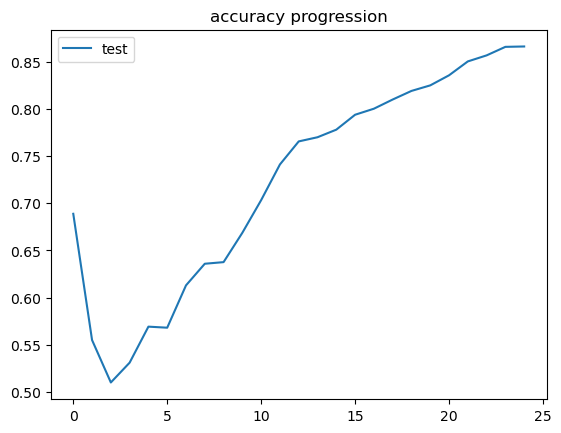

In [35]:
import collections
from time import time
import random
import sklearn
from sklearn.metrics import f1_score, confusion_matrix
import pandas
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
experiment_name = 'test2' #settings['experiment_name']
test = 'bandits' #[20:]
n_epochs = 25 #settings['n_epochs']

p2p = P2P_AFPL(patients_left,data_beats_tr,data_beats_v,test)
accuracies_bandits_2 = p2p.loop(n_epochs,p2p,experiment_name)

In [36]:
print(np.where(p2p.phis>0))

(array([  0,   1,   2,   4,   4,   4,   4,   4,   4,   4,   4,   4,   5,
         5,   5,   7,   8,  10,  11,  12,  13,  13,  13,  15,  15,  16,
        17,  18,  18,  20,  21,  22,  23,  23,  23,  24,  25,  25,  25,
        25,  25,  25,  25,  26,  26,  26,  27,  27,  28,  31,  32,  32,
        32,  33,  34,  35,  36,  37,  37,  38,  38,  39,  41,  41,  41,
        41,  42,  42,  42,  42,  42,  42,  42,  44,  47,  48,  49,  49,
        49,  50,  50,  53,  57,  58,  58,  58,  58,  58,  59,  60,  60,
        60,  60,  60,  61,  63,  63,  63,  63,  65,  65,  65,  65,  67,
        69,  72,  72,  72,  72,  72,  72,  72,  72,  78,  78,  79,  80,
        80,  80,  81,  81,  81,  81,  81,  81,  81,  81,  82,  82,  82,
        82,  82,  82,  84,  84,  84,  84,  85,  86,  87,  87,  88,  90,
        90,  90,  90,  90,  91,  92,  92,  92,  94,  94,  94,  95,  95,
        96,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97, 102,
       102, 102, 102, 105, 105, 106, 107, 108, 108, 108, 108, 1

In [ ]:
import collections
from time import time
import random
import sklearn
from sklearn.metrics import f1_score, confusion_matrix
import pandas
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
experiment_name = 'test' #settings['experiment_name']
test = 'local' #[20:]
n_epochs = 25 #settings['n_epochs']

p2p = P2P_AFPL(patients_left,data_beats_train,data_beats_val,test)
accuracies_bandits_2 = p2p.loop(n_epochs,p2p,experiment_name)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#print(phi)
phi_binary =np.array(np.array(p2p.phis,dtype='bool'),dtype='int')
#print(phi_binary)
phi_graph = nx.from_numpy_array(p2p.phis)

def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def test(g):
# to install networkx 2.0 compatible version of python-louvain use:
    # pip install -U git+https://github.com/taynaud/python-louvain.git@networkx2
    from community import community_louvain

    #g = nx.karate_club_graph()
    partition = community_louvain.best_partition(g)
    print(partition)
    pos = community_layout(g, partition)

    #nx.draw(g, pos, node_color=list(dict_partition.values())); plt.show()

    nodelist = g.nodes()
    widths = nx.get_edge_attributes(g,'weight')
    cmap = plt.cm.get_cmap('cool')#Spectral
    maxval = 27
    plt.figure(figsize=(7,7))
    nx.draw_networkx_nodes(g,pos,nodelist=nodelist,node_size=100,
                          node_color= [cmap(v/maxval) for v in partition.values()])#list(partition.values()))
    print(list(partition.values()))
    labels = [str(i) for i in range(78)]
    #labels = ['healthy','moderately unhealthy','very unhealthy']
    for v in set(partition.values()):
        plt.scatter([],[],c=[cmap(v/maxval)],label=labels[v])

    nx.draw_networkx_edges(g,pos,edgelist=widths.keys(),width=list(widths.values()),edge_color='k')
    plt.legend()
    plt.show()


    return partition

partition = test(phi_graph)


In [ ]:
print(partition)
values = [x for x in partition.values()]
print(values)
values = np.array(values)
unique_partitions = np.unique(values)
print(np.histogram(values,bins=23)[0])
print(np.argwhere(values==4))
print(np.argwhere(values==7))
print(np.argwhere(values==1))
print(np.argwhere(values==11))
print(np.argwhere(values==12))
print(np.argwhere(values==13))

In [ ]:
#print(p2p.phis[15,:])
print(np.max(p2p.phis))
print(np.where(p2p.phis>=5))
print(p2p.phis[14,64])
print(p2p.phis[64,14])
#print(np.where(p2p.phis>0))
print(np.sum(p2p.phis))

In [ ]:
print(np.where(p2p.phis>=5))

In [18]:
patients_healthy = []
patients_unhealthy = []
patients_really_unhealthy = []
for i in range(len(patients_left)):

    mit_bih = MIT_BIH([patients_left[i]],data_beats_train)
    #print('train ',torch.sum(mit_bih.y).numpy()/len(mit_bih.y))
    fraction_train = torch.sum(mit_bih.y).numpy()/len(mit_bih.y)
    mit_bih = MIT_BIH([patients_left[i]],data_beats_test)
    #print('test ',torch.sum(mit_bih.y).numpy()/len(mit_bih.y))
    fraction_test = torch.sum(mit_bih.y).numpy()/len(mit_bih.y)
    if fraction_train == 0:
        patients_healthy.append(patients_left[i])
    else:
        print('patient ',i)
        print('N: ',np.count_nonzero(data_beats_train[patients_left[i]]['class']=='N'))
        print('V: ',np.count_nonzero(data_beats_train[patients_left[i]]['class']=='V'))
        V = np.count_nonzero(data_beats_train[patients_left[i]]['class']=='V')
        S = np.count_nonzero(data_beats_train[patients_left[i]]['class']=='S')
        F = np.count_nonzero(data_beats_train[patients_left[i]]['class']=='F')
        print('S: ',np.count_nonzero(data_beats_train[patients_left[i]]['class']=='S'))
        print('F: ',np.count_nonzero(data_beats_train[patients_left[i]]['class']=='F'))
        if V + S + F >= 10:
          patients_really_unhealthy.append(patients_left[i])
        else:
          patients_unhealthy.append(patients_left[i])
print('healthy patients: ',patients_healthy)
print('moderately unhealthy patients: ',patients_unhealthy)
print('very unhealthy patients: ',patients_really_unhealthy)

patient  0
N:  198
V:  0
S:  3
F:  0
patient  1
N:  154
V:  89
S:  25
F:  0
patient  2
N:  178
V:  1
S:  0
F:  0
patient  3
N:  206
V:  15
S:  0
F:  0
patient  4
N:  294
V:  9
S:  0
F:  0
patient  5
N:  232
V:  14
S:  0
F:  0
patient  6
N:  317
V:  2
S:  4
F:  0
patient  7
N:  205
V:  0
S:  3
F:  0
patient  10
N:  197
V:  6
S:  0
F:  0
patient  11
N:  151
V:  2
S:  0
F:  0
patient  12
N:  178
V:  19
S:  0
F:  0
patient  13
N:  230
V:  1
S:  20
F:  0
patient  14
N:  275
V:  5
S:  55
F:  0
patient  15
N:  128
V:  0
S:  121
F:  0
patient  16
N:  259
V:  0
S:  47
F:  0
patient  17
N:  223
V:  2
S:  33
F:  0
patient  18
N:  270
V:  0
S:  29
F:  0
patient  19
N:  266
V:  0
S:  19
F:  0
patient  20
N:  198
V:  0
S:  1
F:  0
patient  21
N:  158
V:  0
S:  47
F:  0
patient  22
N:  201
V:  0
S:  9
F:  0
patient  24
N:  195
V:  1
S:  2
F:  0
patient  25
N:  267
V:  2
S:  5
F:  0
patient  26
N:  287
V:  2
S:  0
F:  0
patient  28
N:  296
V:  3
S:  9
F:  0
patient  30
N:  175
V:  8
S:  6
F:  0
patien

In [ ]:
patients_healthy = []
for i in range(len(patients_left)):

    print('patient ',i)
    print('N: ',np.count_nonzero(data_beats[patients_left[i]]['class']=='N'))
    print('V: ',np.count_nonzero(data_beats[patients_left[i]]['class']=='V'))
    print('S: ',np.count_nonzero(data_beats[patients_left[i]]['class']=='S'))
    print('F: ',np.count_nonzero(data_beats[patients_left[i]]['class']=='F'))
print('healthy patients: ',patients_healthy)
